![](pics/header.jpg)

# PyTorch

Kevin Walchko, Phd

---

Some of this material comes from Udacities AI course.

## Origins

PyTorch was released in early 2017 and has been making a pretty big impact in the deep learning community. It's developed as an open source project by the Facebook AI Research team.

- tensor: main data structure 
- autograd: automatically calculates gradients for backpropagation

## Simple Network

There are several ways to do this, here is a simple, handcrafted way.

In [29]:
import torch
from torch import nn
from torch import optim
import torchvision
from torchvision import datasets, transforms
from torchinfo import summary
from matplotlib import pyplot as plt
import numpy as np

In [37]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(3*224*224, 256)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(256, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)  # input to hidden layer 
        x = self.sigmoid(x) # activation - sigmoid
        x = self.output(x)  # hidden to output layer
        x = self.softmax(x) # activation - softmax
        
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 256)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 256 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(256, 10)
```

Similarly, this creates another linear transformation with 256 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation and reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [38]:
model = Network()
print("inputs * output + bias:", 784 * 256 + 256)
summary(model)

inputs * output + bias: 200960


Layer (type:depth-idx)                   Param #
Network                                  --
├─Linear: 1-1                            38,535,424
├─Linear: 1-2                            2,570
├─Sigmoid: 1-3                           --
├─Softmax: 1-4                           --
Total params: 38,537,994
Trainable params: 38,537,994
Non-trainable params: 0

In [39]:
model

Network(
  (hidden): Linear(in_features=150528, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

In [13]:
model.hidden

Linear(in_features=784, out_features=256, bias=True)

In [14]:
model.hidden.weight

Parameter containing:
tensor([[-0.0124, -0.0345,  0.0216,  ...,  0.0199, -0.0176, -0.0100],
        [-0.0084, -0.0100,  0.0194,  ..., -0.0056,  0.0285, -0.0205],
        [-0.0090, -0.0337,  0.0313,  ..., -0.0208, -0.0329,  0.0095],
        ...,
        [ 0.0258, -0.0252, -0.0041,  ...,  0.0263, -0.0156, -0.0042],
        [ 0.0039, -0.0190,  0.0301,  ..., -0.0204,  0.0043, -0.0231],
        [ 0.0086, -0.0278,  0.0345,  ...,  0.0271, -0.0301,  0.0143]],
       requires_grad=True)

## Data

`torchvision` as classes to help load image data and can help manipulate the data to enable training a more robust NN.

In [19]:
data_dir = "flowers"
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)

tensor([[1, 2, 2, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 2, 1, 1],
        [0, 2, 0, 0, 0, 1, 0, 2],
        [1, 1, 2, 0, 1, 2, 2, 1],
        [0, 2, 1, 1, 1, 1, 0, 0],
        [2, 2, 0, 1, 1, 1, 2, 2],
        [2, 0, 1, 1, 1, 0, 2, 0],
        [2, 1, 0, 0, 0, 0, 1, 1]])


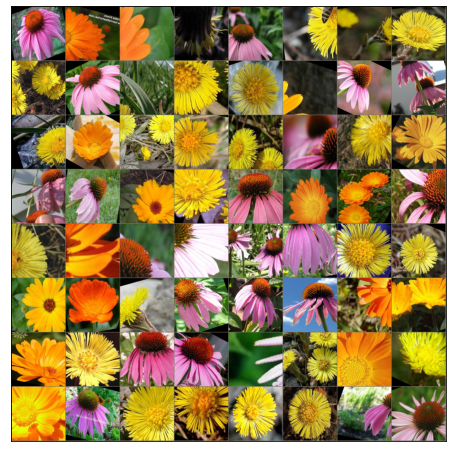

In [31]:
def make_grid(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    npimg = np.transpose(npimg, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    npimg = std * npimg + mean
    npimg = np.clip(npimg, 0, 1)
    npimg.astype(np.uint8)
    plt.imshow(npimg)
    plt.xticks([])
    plt.yticks([]);

images, labels = next(iter(trainloader))

make_grid(torchvision.utils.make_grid(images))
print(labels.reshape(8,8))

## Training

Typically it's more convenient to build the model with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

In [41]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for ii, (inputs, labels) in enumerate(trainloader):
    inputs = inputs.view(inputs.shape[0], -1) # resize imagery to fit inputs
    print(inputs.shape)
    outputs = model(inputs) # get model output
    loss = criterion(outputs, labels) # determine error

    optimizer.zero_grad() # clear gradient from last run
    loss.backward()       # update gradient
    optimizer.step()      # step towards lowest level
    
    print(f"{ii+1}/{len(trainloader)}")

torch.Size([64, 150528])
1/3
torch.Size([64, 150528])
2/3
torch.Size([59, 150528])
3/3


## GPU Support

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...)
model.to(device)
```

In [42]:
torch.cuda.is_available()

False